### Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt


In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


### Setup device agnostic code

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
print(device)

cuda


In [6]:
# CUDA Diagnostics
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("CUDA Device Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)

CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 4050 Laptop GPU
CUDA Version: 12.1
PyTorch Version: 2.5.1+cu121
Torchvision Version: 0.20.1+cu121


In [7]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

### Setting the hyperparameters

In [8]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.0003
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
EMBED_DIM = 256
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1
CHANNELS  = 3
NUM_HEADS = 8

### Define image transformations

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)), #helps the model to converge faster, also helps to make the numerical computation stable
])

### Getting a dataset

In [10]:
train_dataset = datasets.CIFAR10(root='data',
                                 train=True,
                                 download=True,
                                 transform=transform)

Files already downloaded and verified


In [11]:
test_dataset = datasets.CIFAR10(root='data',
                                train=False,
                                download=True,
                                transform=transform)

Files already downloaded and verified


In [12]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [13]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [14]:
print(len(train_dataset))
print(len(test_dataset))

50000
10000


### Converting the datasets into dataloaders:
Our data is in the form of pytorch dataset, data,oasers turn the data into batches or mini-batches that makes more computationally efficient.

In [15]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

In [16]:
print(f"DataLoader: {train_loader, test_loader}")
print(f"Length of train_loader: {len(train_loader)}")
print(f"Length of test_loader: {len(test_loader)}")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x000002863072D350>, <torch.utils.data.dataloader.DataLoader object at 0x000002860956FBD0>)
Length of train_loader: 391
Length of test_loader: 79


### Building vision transformer model

In [17]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x)  # (B, E, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        return x


In [18]:
class MLP(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features,
                             out_features=in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [19]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

In [20]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes,
                 embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(
            *[TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
              for _ in range(depth)]
        )
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)        # (B, N+1, E)
        x = self.encoder(x)            # (B, N+1, E)
        x = self.norm(x)               # (B, N+1, E)
        cls_token = x[:, 0]            # (B, E)
        return self.head(cls_token)    # (B, num_classes)


### Instantiate model

In [21]:
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES, EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)

In [22]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

### Defining a Loss function and an optimizer

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr = LEARNING_RATE)

In [24]:
criterion

CrossEntropyLoss()

In [25]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

### Defininng a training loop function

In [31]:
def train(model, loader, optimizer, criterion):
    # set the mode for the model into trainig
    model.train()

    total_loss , correct = 0, 0
    
    for x, y in loader:
        # moving (sending ) our data to the target device
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        # 1. forward pass (model outputs raw logits)
        out = model(x)
        # 2. calculate the loss
        loss = criterion(out, y)
        # 3. Perform back propagation
        loss.backward()
        # 4. Perform gradient descent
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    # to scale the loss (normalization step to make the loss general across all batches)
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

### Evaluation function to evaluate model

In [35]:
def evaluate(model, loader):
    model.eval() # set the mode of the model in evaluation mode
    correct = 0
    with torch.inference_mode():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(1) == y).sum().item()

    return correct / len(loader.dataset)

### Training

In [36]:
from tqdm.auto import tqdm

In [37]:
train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f"Epoch: {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}% | Test Acc: {test_acc:.4f}%")


 10%|█         | 1/10 [00:34<05:08, 34.24s/it]

Epoch: 1/10, Train Loss: 1.2322 | Train Acc: 0.5573% | Test Acc: 0.5710%


 20%|██        | 2/10 [01:08<04:33, 34.15s/it]

Epoch: 2/10, Train Loss: 1.1188 | Train Acc: 0.6008% | Test Acc: 0.5887%


 30%|███       | 3/10 [01:42<03:59, 34.22s/it]

Epoch: 3/10, Train Loss: 1.0325 | Train Acc: 0.6322% | Test Acc: 0.6084%


 40%|████      | 4/10 [02:16<03:24, 34.15s/it]

Epoch: 4/10, Train Loss: 0.9574 | Train Acc: 0.6599% | Test Acc: 0.6129%


 50%|█████     | 5/10 [02:50<02:50, 34.13s/it]

Epoch: 5/10, Train Loss: 0.8826 | Train Acc: 0.6861% | Test Acc: 0.6159%


 60%|██████    | 6/10 [03:24<02:16, 34.11s/it]

Epoch: 6/10, Train Loss: 0.8102 | Train Acc: 0.7096% | Test Acc: 0.6282%


 70%|███████   | 7/10 [03:58<01:42, 34.12s/it]

Epoch: 7/10, Train Loss: 0.7349 | Train Acc: 0.7387% | Test Acc: 0.6293%


 80%|████████  | 8/10 [04:33<01:08, 34.11s/it]

Epoch: 8/10, Train Loss: 0.6688 | Train Acc: 0.7608% | Test Acc: 0.6344%


 90%|█████████ | 9/10 [05:07<00:34, 34.28s/it]

Epoch: 9/10, Train Loss: 0.6027 | Train Acc: 0.7854% | Test Acc: 0.6364%


100%|██████████| 10/10 [05:42<00:00, 34.28s/it]

Epoch: 10/10, Train Loss: 0.5367 | Train Acc: 0.8083% | Test Acc: 0.6374%


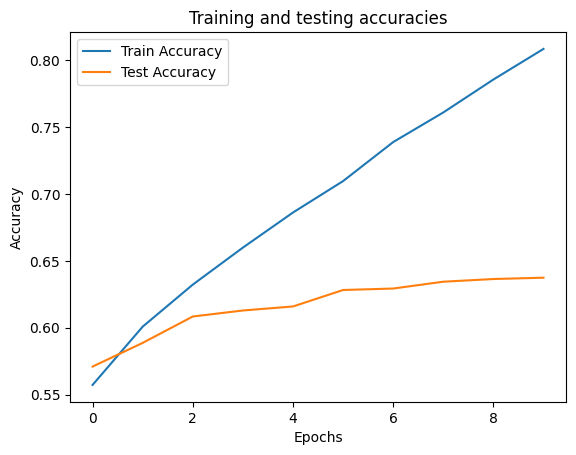

In [38]:
# plot accuracy
plt.plot(train_accuracies, label = "Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and testing accuracies")
plt.show()

### fuction for the prediction

In [43]:
def predic_and_plot(model, dataset, classes, grid_size = 3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize = (9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset)-1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5  # unormalize the images to be able to plot them with matplotlib
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"
            
            axes[i, j].set_title(f"Truth: {classes[true_label]}\n Predicted: {classes[predicted.item()]}", fontsize = 10, c=color)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()


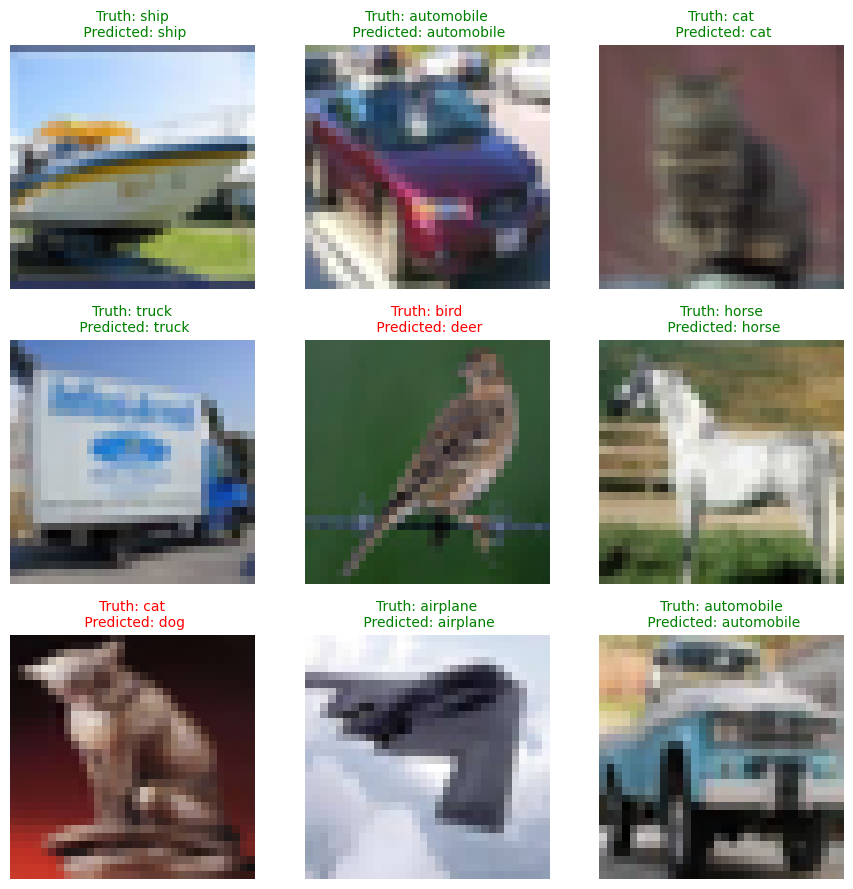

In [48]:
predic_and_plot(model, test_dataset, classes=train_dataset.classes, grid_size=3)